In [13]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report

import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
files = ['open_eyes.pkl', 'closed_eyes.pkl']

In [3]:
i = 0
for file in files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        # save first file
        if i == 0:
            train_dataset = data['train_dataset']
            train_labels = data['train_labels']
            test_dataset = data['test_dataset']
            test_labels = data['test_labels']
        # then add any others
        else:
            train_dataset = np.concatenate((train_dataset, data['train_dataset']))
            train_labels = np.concatenate((train_labels, data['train_labels']))
            test_dataset = np.concatenate((test_dataset, data['test_dataset']))
            test_labels = np.concatenate((test_labels, data['test_labels']))
        del(data)
    i+=1

            
            

In [4]:
print(train_dataset.shape, train_labels.shape)
print(test_dataset.shape, test_labels.shape)

(3448, 24, 24, 1) (3448, 1)
(1480, 24, 24, 1) (1480, 1)


In [5]:
X_train = train_dataset
y_train = train_labels
X_test = test_dataset
y_test = test_labels

In [6]:
X_train.shape

(3448, 24, 24, 1)

In [7]:
# image dimensions
_, img_channels, img_rows, img_cols = X_train.shape

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
          input_shape=(img_channels, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), padding= 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (2,2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Fully connected layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Output Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

# train with Adam
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

### Data Augmentation

In [9]:
# scale values between 0 and 1 for faster learning
X_train /= 255
X_test /= 255
datagen = ImageDataGenerator(rotation_range=10,
                            width_shift_range=0.2,
                            height_shift_range=0.2)
datagen.fit(X_train)

H = model.fit_generator(datagen.flow(X_train,y_train,batch_size=32),
                        validation_data=(X_test, y_test),
                        steps_per_epoch=len(X_train) / 32, epochs=50)
print("[INFO] evaluating network...")
predictions = model.predict(X_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1), 
                            target_names=['open', 'closed']))

Epoch 1/50
108/107 [==============================] - 3s 31ms/step - loss: 0.6622 - acc: 0.5864 - val_loss: 0.6110 - val_acc: 0.6581
Epoch 2/50
108/107 [==============================] - 2s 19ms/step - loss: 0.5549 - acc: 0.7094 - val_loss: 0.4153 - val_acc: 0.8311
Epoch 3/50
108/107 [==============================] - 2s 19ms/step - loss: 0.4197 - acc: 0.8101 - val_loss: 0.2834 - val_acc: 0.8973
Epoch 4/50
108/107 [==============================] - 2s 19ms/step - loss: 0.2962 - acc: 0.8811 - val_loss: 0.2453 - val_acc: 0.9014
Epoch 5/50
108/107 [==============================] - 2s 19ms/step - loss: 0.2595 - acc: 0.8994 - val_loss: 0.2012 - val_acc: 0.9223
Epoch 6/50
108/107 [==============================] - 2s 19ms/step - loss: 0.2345 - acc: 0.9023 - val_loss: 0.2193 - val_acc: 0.9209
Epoch 7/50
108/107 [==============================] - 2s 19ms/step - loss: 0.2113 - acc: 0.9173 - val_loss: 0.1481 - val_acc: 0.9500
Epoch 8/50
108/107 [==============================] - 2s 19ms/step - 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 1, does not match size of target_names, 2
  .format(len(labels), len(target_names))


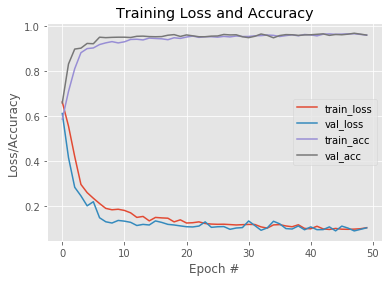

In [10]:
# plot the training loss and accuracy
N = np.arange(0, 50)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


In [11]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Loss score:', score[0])
print('Test accuracy:', score[1] * 100, '%')

Loss score: 0.10334648468525376
Test accuracy: 95.94594594594594 %


In [16]:
model_json = model.to_json()
with open('trained_model/model.json', "w") as json_file:
    json_file.write(model_json)

model.save_weights('trained_model/weights.h5', overwrite=True)